# 2.3 SOO for 2D vector field

We load the necessary objects.

In [1]:
import numpy as np

from cyclops.object_reader import PickleManager
from cyclops.plotting import PlotManager

# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = PlotManager()
true_temp_field = pickle_manager.read_file("results/disp_plane_field.pickle")
grid = pickle_manager.read_file("results/disp_plane_points.pickle")

field_bounds = true_temp_field.get_bounds()
sensor_bounds = field_bounds + np.array([[1, 1], [-1, -1]]) * 0.002

We setup the sensor suite

In [2]:
from cyclops.fields import VectorField
from cyclops.regressors import RBFModel
from cyclops.sensor_suite import SensorSuite, SymmetryManager
from cyclops.sensors import PointSensor

# Setup the symmetry
symmetry_manager = SymmetryManager()
symmetry_manager.set_2D_x(np.mean(field_bounds[:, 0]))


# Setup the sensor suite
def f(x):
    return np.zeros(x.shape)


sensor = PointSensor(0, f, 0, np.array([[-5e10, -5e10, -5e10], [5e10, 5e10, 5e10]]), 2)
sensors = np.array([sensor] * 5)

sensor_suite = SensorSuite(
    VectorField(RBFModel, field_bounds),
    sensors,
    symmetry=[symmetry_manager.reflect_2D_horiz],
)

We setup the optimisation.

In [3]:
from cyclops.experiment import Experiment
from cyclops.optimisers import PSOOptimiser

# Setup the experiment
optimiser = PSOOptimiser("00:00:10")
experiment = Experiment(
    true_temp_field,
    grid,
    optimiser,
)
experiment.plan_soo(
    sensor_suite,
    sensor_bounds,
)
res = experiment.design()
(
    proposed_layout,
    true_disps,
    model_disps,
    sensor_vals,
) = experiment.get_SOO_plotting_arrays(res.X)

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       30 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  9.871195E-11 |  5.556388E-11
     2 |       60 |  0.47379 |       2 |  0.6956 |  2.04461 |  1.95539 |  8.194007E-11 |  4.759107E-11
     3 |       90 |  0.31883 |       2 |  0.6043 |  2.08455 |  1.91545 |  7.490565E-11 |  4.759107E-11
     4 |      120 | -1.4E-02 |       3 |  0.3915 |  2.08300 |  1.93538 |  6.399480E-11 |  4.369771E-11


We plot the mangitudes of the fields to compare.

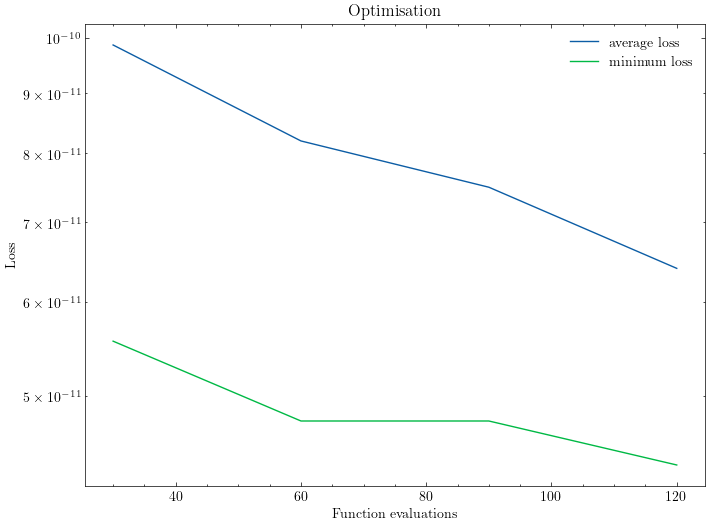

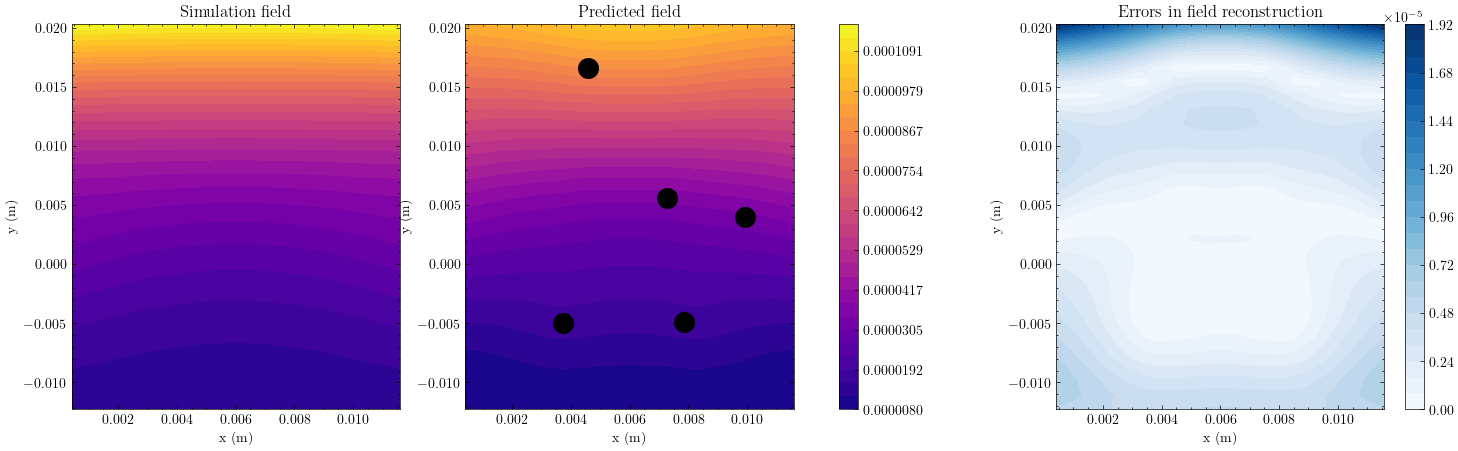

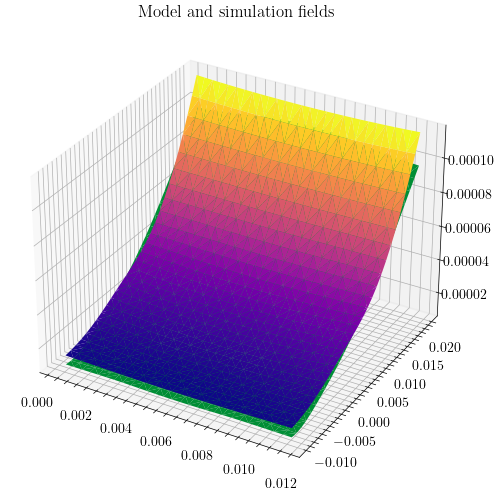

In [4]:
mag_true_disps = np.linalg.norm(true_disps, axis=1).reshape(-1, 1)
mag_model_disps = np.linalg.norm(model_disps, axis=1).reshape(-1, 1)
mag_sensor_vals = np.linalg.norm(sensor_vals, axis=1).reshape(-1, 1)

# Display the results
graph_manager.build_optimisation(res.history)
graph_manager.draw()
graph_manager.build_2D_compare(grid, proposed_layout, mag_true_disps, mag_model_disps)
graph_manager.draw()
graph_manager.build_3D_compare(grid, mag_true_disps, mag_model_disps)
graph_manager.draw()